<a href="https://colab.research.google.com/github/pooriaazami/deep_learning_class_notebooks/blob/main/7_Neural_Style_Transfer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim

from torchvision import transforms as T, models

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from google.colab import files
from PIL import Image

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = 640
VGG_PREPROCESSING_MEAN = (.485, .486, .406)
VGG_PREPROCESSING_STD = (.229, .224, .225)
LR = 3e-3

In [3]:
transforms = T.Compose([
  T.Resize(IMAGE_SIZE),
  T.ToTensor(),
  T.Normalize(VGG_PREPROCESSING_MEAN, VGG_PREPROCESSING_STD)
])

In [4]:
def upload_file():
  uploaded_files = files.upload()
  uploaded_files = list(uploaded_files.keys())
  path = uploaded_files[0]

  print(f"uploaded file's path: {path}")

  return path

In [5]:
def open_image(image_path):
  img = Image.open(image_path).convert('RGB')
  img = transforms(img).unsqueeze(0)

  return img

In [6]:
def get_features(model, image, layers):
  features = {}

  x = image
  for name, layer in model.named_children():
    x = layer(x)

    if name in layers:
      features[layers[name]] = x

  return features

In [7]:
def content_loss(target, content, layer):
  return torch.mean((target[layer] - content[layer]) ** 2)

In [8]:
def gram_matrix(tensor):
  _, c, h, w = tensor.size()

  tensor = tensor.view(c, h * w)
  gram = torch.mm(tensor, tensor.t())

  return gram

In [9]:
def style_loss(target, style_grams, weigths):
  loss = .0
  for layer in weigths:
    target_features = target[layer]
    style_features_gram = style_grams[layer]

    target_features_gram = gram_matrix(target_features)

    _, c, w, h = target_features.size()
    loss += weigths[layer] * torch.mean((target_features_gram - style_features_gram) ** 2) / (c * w * h)

  return loss

In [10]:
vgg = models.vgg19(pretrained=True).features.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
for param in vgg.parameters():
  param.requires_grad_(False)

In [12]:
content_file = upload_file()
style_file = upload_file()

Saving shima.jpg to shima (1).jpg
uploaded file's path: shima (1).jpg


Saving 8.png to 8.png
uploaded file's path: 8.png


In [13]:
content_image = open_image(content_file).to(DEVICE)
style_image = open_image(style_file).to(DEVICE)

In [14]:
layers = {
    '0': 'conv_1_1',
    '5': 'conv_2_1',
    '10': 'conv_3_1',
    '19': 'conv_4_1',
    '21': 'conv_4_2',
    '28': 'conv_5_1'
}

In [15]:
layer_weights = {
    'conv_1_1': 1.,
    'conv_2_1': .75,
    'conv_3_1': .2,
    'conv_4_1': .2,
    # 'conv_4_2': content-loss
    'conv_5_1': .2
}

In [16]:
content_features = get_features(vgg, content_image, layers)
style_features = get_features(vgg, style_image, layers)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content_image.clone().to(DEVICE)
target.requires_grad = True

In [17]:
optimizer = optim.Adam([target], lr=LR)

In [18]:
content_loss_weight = 1
style_loss_weight = 1e6

In [19]:
steps = 2000
content_loss_layer = 'conv_4_2'

for _ in tqdm(range(steps)):
  optimizer.zero_grad()
  target_features = get_features(vgg, target, layers)

  content_loss_value = content_loss(target_features, content_features, content_loss_layer)
  style_loss_value = style_loss(target_features, style_grams, layer_weights)

  loss = content_loss_weight * content_loss_value + style_loss_weight * style_loss_value

  loss.backward()
  optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

In [20]:
target = target.detach().cpu().numpy().squeeze()
target = target.transpose(1, 2, 0)
target = target * np.array(VGG_PREPROCESSING_STD) + np.array(VGG_PREPROCESSING_MEAN)
target = target.clip(0, 1)
target = Image.fromarray(np.uint8(target * 255))

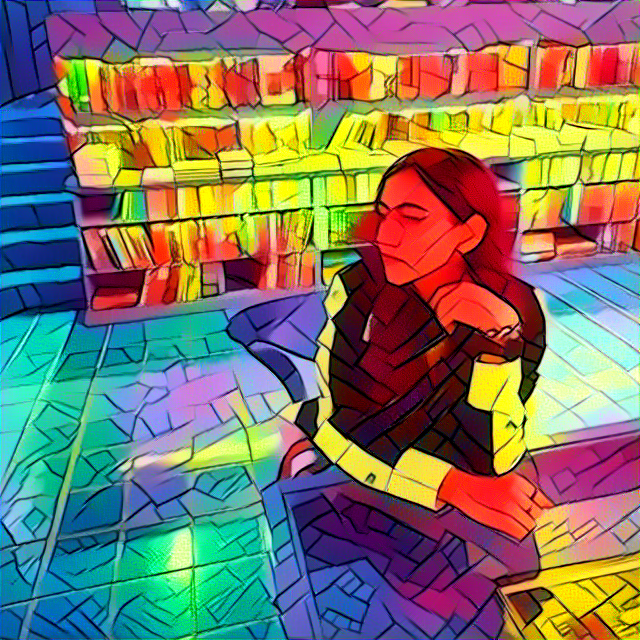

In [21]:
target

In [22]:
target.save('target.jpg')

In [74]:
files.download('target.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>